# Facebook Graph VAE
---
Created by Lucas Hu for Teamcore AI Lab at the University of Southern California. The purpose of this notebook is to apply Graph VAE's to social network graph data (mainly, Facebook friend data) for the purposes of link prediction.

## 1. Read in Graph Data

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
EDGES_DIR = 'facebook/0.edges'
FEATURES_DIR = 'facebook/0.feat'

In [3]:
# Read edge-list
f = open(EDGES_DIR)
g = nx.read_edgelist(f, nodetype=int)

In [4]:
# read features into dataframe
from pandas import read_table
df = pd.read_table(FEATURES_DIR, sep=' ', header=None, index_col=0)

In [5]:
df = df.loc[g.nodes()] # only keep connected nodes (drops unconnected nodes)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,215,216,217,218,219,220,221,222,223,224
0,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


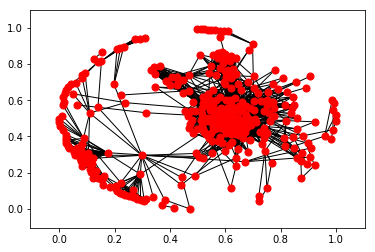

In [6]:
# draw network
nx.draw_networkx(g, with_labels=False, node_size=50, node_color='r')
plt.show()

In [7]:
adj = nx.adjacency_matrix(g) # get adjacency matrix in sparse format
features = df.values # features matrix

## 2. Data Preprocessing

In [8]:
from __future__ import division
from __future__ import print_function

import time
import os

# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = ""

import tensorflow as tf
tf.set_random_seed(0)
import numpy as np
import scipy.sparse as sp

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from gae.optimizer import OptimizerAE, OptimizerVAE
from gae.model import GCNModelAE, GCNModelVAE
from gae.preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges

In [9]:
# Convert features from normal matrix --> sparse matrix --> tuple
    # features_tuple contains: (list of matrix coordinates, list of values, matrix dimensions)
import scipy.sparse as sp
x = sp.lil_matrix(features)
features_tuple = sparse_to_tuple(x)
features_shape = features_tuple[2]

In [10]:
# Get graph attributes (to feed into model)
num_nodes = adj.shape[0] # number of nodes in adjacency matrix
num_features = features_shape[1] # number of features (columsn of features matrix)
features_nonzero = features_tuple[1].shape[0] # number of non-zero entries in features matrix (or length of values list)

In [11]:
# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

np.random.seed(0) # IMPORTANT: guarantees consistent train/test splits
adj_train, train_edges, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges(adj, test_frac=.3, val_frac=.1)

# Normalize adjacency matrix
adj_norm = preprocess_graph(adj_train)

# Add in diagonals
adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

In [12]:
# Inspect train/test split
print("Total nodes:", adj_orig.shape[0])
print("Total edges:", int(adj_orig.nnz/2)) # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print("Training edges (positive):", len(train_edges))
print("Validation edges (positive):", len(val_edges))
print("Validation edges (negative):", len(val_edges_false))
print("Test edges (positive):", len(test_edges))
print("Test edges (negative):", len(test_edges_false))

Total nodes: 333
Total edges: 2519
Training edges (positive): 1513
Validation edges (positive): 251
Validation edges (negative): 251
Test edges (positive): 755
Test edges (negative): 755


## 3. Initialize VAE Model

In [13]:
# Define hyperparameters
LEARNING_RATE = 0.005
EPOCHS = 300
HIDDEN1_DIM = 32
HIDDEN2_DIM = 16
DROPOUT = 0.1

In [14]:
# Define placeholders
placeholders = {
    'features': tf.sparse_placeholder(tf.float32),
    'adj': tf.sparse_placeholder(tf.float32),
    'adj_orig': tf.sparse_placeholder(tf.float32),
    'dropout': tf.placeholder_with_default(0., shape=())
}

In [15]:
# How much to weigh positive examples (true edges) in cost print_function
  # Want to weigh less-frequent classes higher, so as to prevent model output bias
  # pos_weight = (num. negative samples / (num. positive samples)
pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()

# normalize (scale) average weighted cost
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

In [16]:
# Create VAE model
model = GCNModelVAE(placeholders, num_features, num_nodes, features_nonzero,
                   HIDDEN1_DIM, HIDDEN2_DIM)

opt = OptimizerVAE(preds=model.reconstructions,
                           labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                       validate_indices=False), [-1]),
                           model=model, num_nodes=num_nodes,
                           pos_weight=pos_weight,
                           norm=norm,
                           learning_rate=LEARNING_RATE)

In [17]:
# Calculate ROC AUC
def get_roc_score(edges_pos, edges_neg, emb=None):
    if emb is None:
        feed_dict.update({placeholders['dropout']: 0})
        emb = sess.run(model.z_mean, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]])) # predicted score for given edge
        pos.append(adj_orig[e[0], e[1]]) # actual value (1)

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]])) # predicted score for given edge
        neg.append(adj_orig[e[0], e[1]]) # actual value (0)

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

## 4. Train and Evaluate VAE Model

In [18]:
cost_val = []
acc_val = []
val_roc_score = []

# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Train model
for epoch in range(EPOCHS):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features_tuple, placeholders)
    feed_dict.update({placeholders['dropout']: DROPOUT})
    # Run single weight update
    outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)

    # Compute average loss
    avg_cost = outs[1]
    avg_accuracy = outs[2]

    # Evaluate predictions
    roc_curr, ap_curr = get_roc_score(val_edges, val_edges_false)
    val_roc_score.append(roc_curr)

    # Print results for this epoch
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
          "train_acc=", "{:.5f}".format(avg_accuracy), "val_roc=", "{:.5f}".format(val_roc_score[-1]),
          "val_ap=", "{:.5f}".format(ap_curr),
          "time=", "{:.5f}".format(time.time() - t))

print("Optimization Finished!")

# Print final results
roc_score, ap_score = get_roc_score(test_edges, test_edges_false)
print('Test ROC score: ' + str(roc_score))
print('Test AP score: ' + str(ap_score))

Epoch: 0001 train_loss= 1.86273 train_acc= 0.45520 val_roc= 0.73116 val_ap= 0.74949 time= 0.06322
Epoch: 0002 train_loss= 1.69931 train_acc= 0.46023 val_roc= 0.73250 val_ap= 0.74053 time= 0.02737
Epoch: 0003 train_loss= 1.49957 train_acc= 0.48763 val_roc= 0.73628 val_ap= 0.73261 time= 0.02775
Epoch: 0004 train_loss= 1.33567 train_acc= 0.49295 val_roc= 0.74803 val_ap= 0.74162 time= 0.02725
Epoch: 0005 train_loss= 1.37490 train_acc= 0.48377 val_roc= 0.76152 val_ap= 0.75986 time= 0.02702
Epoch: 0006 train_loss= 1.36146 train_acc= 0.48011 val_roc= 0.77336 val_ap= 0.77843 time= 0.02689
Epoch: 0007 train_loss= 1.26192 train_acc= 0.48734 val_roc= 0.78482 val_ap= 0.79431 time= 0.02708
Epoch: 0008 train_loss= 1.24528 train_acc= 0.49046 val_roc= 0.79239 val_ap= 0.80169 time= 0.02915
Epoch: 0009 train_loss= 1.22842 train_acc= 0.49351 val_roc= 0.79600 val_ap= 0.80476 time= 0.03073
Epoch: 0010 train_loss= 1.22352 train_acc= 0.49066 val_roc= 0.80047 val_ap= 0.80805 time= 0.02778
Epoch: 0011 train_lo

Epoch: 0088 train_loss= 0.52655 train_acc= 0.53967 val_roc= 0.86707 val_ap= 0.86388 time= 0.02771
Epoch: 0089 train_loss= 0.52578 train_acc= 0.54369 val_roc= 0.86876 val_ap= 0.86337 time= 0.02834
Epoch: 0090 train_loss= 0.52826 train_acc= 0.53739 val_roc= 0.86953 val_ap= 0.86307 time= 0.03027
Epoch: 0091 train_loss= 0.52480 train_acc= 0.53741 val_roc= 0.87014 val_ap= 0.86361 time= 0.02867
Epoch: 0092 train_loss= 0.52767 train_acc= 0.53945 val_roc= 0.87026 val_ap= 0.86385 time= 0.02749
Epoch: 0093 train_loss= 0.52490 train_acc= 0.53927 val_roc= 0.87028 val_ap= 0.86518 time= 0.03051
Epoch: 0094 train_loss= 0.52289 train_acc= 0.53911 val_roc= 0.87017 val_ap= 0.86723 time= 0.02961
Epoch: 0095 train_loss= 0.52878 train_acc= 0.53990 val_roc= 0.86830 val_ap= 0.86751 time= 0.03037
Epoch: 0096 train_loss= 0.52608 train_acc= 0.54639 val_roc= 0.86709 val_ap= 0.86679 time= 0.02735
Epoch: 0097 train_loss= 0.52804 train_acc= 0.54392 val_roc= 0.86742 val_ap= 0.86701 time= 0.02750
Epoch: 0098 train_lo

Epoch: 0177 train_loss= 0.51458 train_acc= 0.54894 val_roc= 0.88482 val_ap= 0.87994 time= 0.02884
Epoch: 0178 train_loss= 0.51870 train_acc= 0.55204 val_roc= 0.88442 val_ap= 0.88051 time= 0.02681
Epoch: 0179 train_loss= 0.51686 train_acc= 0.54459 val_roc= 0.88393 val_ap= 0.88105 time= 0.02669
Epoch: 0180 train_loss= 0.51359 train_acc= 0.54805 val_roc= 0.88337 val_ap= 0.88080 time= 0.02747
Epoch: 0181 train_loss= 0.51286 train_acc= 0.55536 val_roc= 0.88414 val_ap= 0.88132 time= 0.02702
Epoch: 0182 train_loss= 0.51335 train_acc= 0.55047 val_roc= 0.88490 val_ap= 0.88110 time= 0.02694
Epoch: 0183 train_loss= 0.51665 train_acc= 0.54908 val_roc= 0.88612 val_ap= 0.88197 time= 0.02727
Epoch: 0184 train_loss= 0.51261 train_acc= 0.55485 val_roc= 0.88672 val_ap= 0.88197 time= 0.02672
Epoch: 0185 train_loss= 0.51436 train_acc= 0.54827 val_roc= 0.88688 val_ap= 0.88199 time= 0.02834
Epoch: 0186 train_loss= 0.51215 train_acc= 0.54948 val_roc= 0.88679 val_ap= 0.88220 time= 0.02697
Epoch: 0187 train_lo

Epoch: 0268 train_loss= 0.50558 train_acc= 0.55583 val_roc= 0.89985 val_ap= 0.89445 time= 0.02831
Epoch: 0269 train_loss= 0.50442 train_acc= 0.55581 val_roc= 0.90103 val_ap= 0.89603 time= 0.02697
Epoch: 0270 train_loss= 0.50706 train_acc= 0.55628 val_roc= 0.90204 val_ap= 0.89687 time= 0.02714
Epoch: 0271 train_loss= 0.50995 train_acc= 0.54713 val_roc= 0.90179 val_ap= 0.89700 time= 0.03006
Epoch: 0272 train_loss= 0.50817 train_acc= 0.54841 val_roc= 0.90076 val_ap= 0.89581 time= 0.02720
Epoch: 0273 train_loss= 0.50791 train_acc= 0.55812 val_roc= 0.90049 val_ap= 0.89596 time= 0.02733
Epoch: 0274 train_loss= 0.50546 train_acc= 0.55904 val_roc= 0.89976 val_ap= 0.89540 time= 0.02857
Epoch: 0275 train_loss= 0.50705 train_acc= 0.55821 val_roc= 0.89907 val_ap= 0.89437 time= 0.02838
Epoch: 0276 train_loss= 0.50313 train_acc= 0.56438 val_roc= 0.89841 val_ap= 0.89368 time= 0.02842
Epoch: 0277 train_loss= 0.50647 train_acc= 0.56153 val_roc= 0.89841 val_ap= 0.89332 time= 0.02763
Epoch: 0278 train_lo